In [91]:
from torchvision import datasets
import collections
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from augmentation import *

In [93]:
data_path = './data'

In [94]:
train_dataset = datasets.CIFAR10(data_path, train=True, download=True)
test_dataset = datasets.CIFAR10(data_path, train=False, download=False)

Files already downloaded and verified


In [95]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [96]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [97]:
train_dataset.targets[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

In [98]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [99]:
test_dataset.data.shape

(10000, 32, 32, 3)

In [100]:
collections.Counter(train_dataset.targets)

Counter({6: 5000,
         9: 5000,
         4: 5000,
         1: 5000,
         2: 5000,
         7: 5000,
         8: 5000,
         3: 5000,
         5: 5000,
         0: 5000})

In [101]:
collections.Counter(test_dataset.targets)

Counter({3: 1000,
         8: 1000,
         0: 1000,
         6: 1000,
         1: 1000,
         9: 1000,
         5: 1000,
         7: 1000,
         4: 1000,
         2: 1000})

In [102]:
train_dataset.class_to_idx.keys()

dict_keys(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [103]:
train_dataset.class_to_idx.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

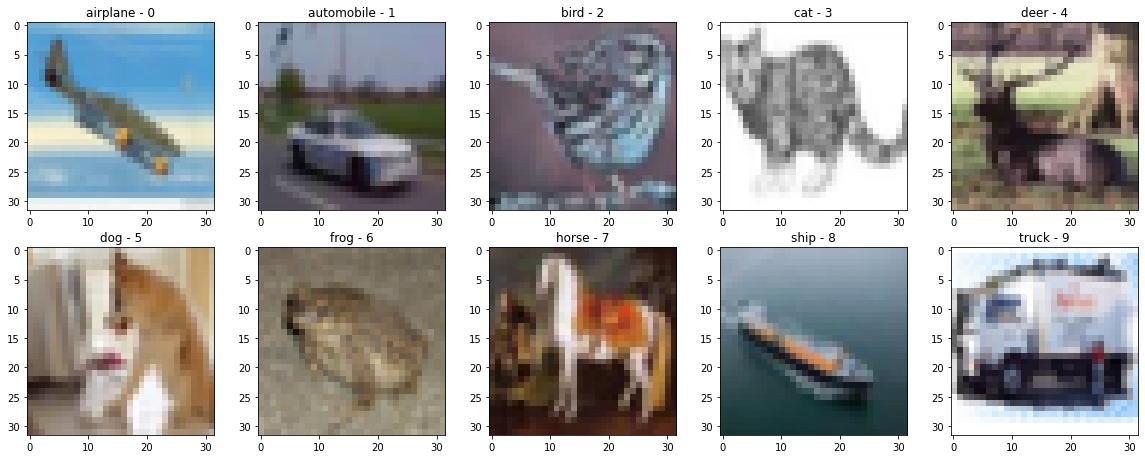

In [109]:
np.random.seed(0)
fig = plt.figure(figsize=(20, 20))
for cls, i in zip(train_dataset.class_to_idx.keys(), train_dataset.class_to_idx.values()):
    index_list = np.where(np.array(train_dataset.targets)==i)[0]
    index = np.random.choice(index_list, 1, replace=False)
    img = train_dataset.data[index][0]
    
    fig.add_subplot(5, 5, i+1)
    plt.imshow(img)
    plt.title(f'{cls} - {i}')
plt.show()

In [105]:
def rand_augment_pool():
    augs = [
        (AutoContrast, None, None),
        (Equalize, None, None),
        (Invert, None, None),
        (Rotate, 30, None),
        (Posterize, 4, 0),
        (Solarize, 256, None),
        (Color, 1.8, 0.1),
        (Contrast, 1.8, 0.1),
        (Brightness, 1.8, 0.1),
        (Sharpness, 1.8, 0.1),
        (ShearX, 0.3, None),
        (ShearY, 0.3, None),
        (TranslateXConst, 100, None),
        (TranslateYConst, 100, None),
    ]
    return augs

In [113]:
class RandAugment(object):
    def __init__(self, n, m, resample_mode=PIL.Image.BICUBIC, fill=(128, 128, 128)):
        global RESAMPLE_MODE, FILL_COLOR
        RESAMPLE_MODE = resample_mode
        FILL_COLOR = fill
        
        self.n = int(n)
        self.m = m
        self.augment_pool = rand_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            img = op(img, v=self.m, max_v=max_v, bias=bias)
        return img

In [114]:
path = 'air_plane.jpg'
image = Image.open(path).convert('RGB')

In [115]:
n = 5
m = 10
ra = RandAugment(n, m)
transform_image = ra(image)

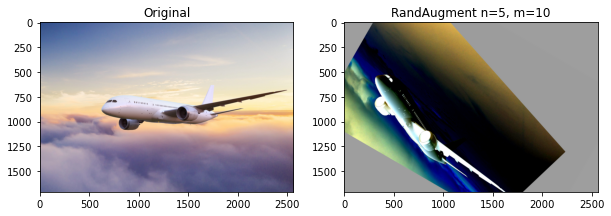

In [116]:
np.random.seed(0)
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original')

fig.add_subplot(1, 2, 2)
plt.imshow(transform_image)
plt.title(f'RandAugment n={n}, m={m}')

plt.show()

In [120]:
def cifar_augment_pool():
    augs = [
        (AutoContrast, None, None),
        (Equalize, None, None),
        (Invert, None, None),
        (Rotate, 30, None),
        (Posterize, 4, 0),
        (Solarize, 256, None),
        (Color, 1.8, 0.1),
        (Contrast, 1.8, 0.1),
        (Brightness, 1.8, 0.1),
        (Sharpness, 1.8, 0.1),
        (ShearX, 0.3, None),
        (ShearY, 0.3, None),
        (TranslateXConst, 32 // 8, None),
        (TranslateYConst, 32 // 8, None),
        (CutoutConst, 32 // 8, None),
    ]
    return augs

In [126]:
class RandAugmentCIFAR(object):
    def __init__(self, n, m, resample_mode=PIL.Image.BICUBIC, fill=(128, 128, 128)):
        global RESAMPLE_MODE, FILL_COLOR
        RESAMPLE_MODE = resample_mode
        FILL_COLOR = fill
        self.n = int(n)
        self.m = m
        self.augment_pool = cifar_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            img = op(img, v=self.m, max_v=max_v, bias=bias)
        img = CutoutConst(img, v=self.m, max_v=32 // 4)
        return img

In [130]:
ra_cifar = RandAugmentCIFAR(2, 10)

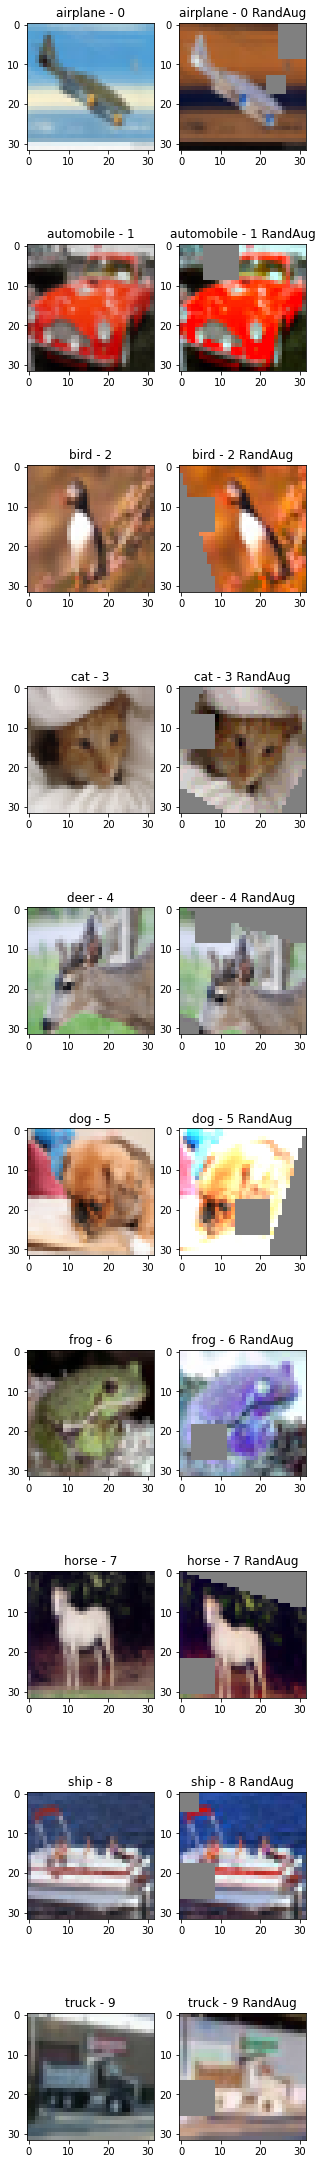

In [146]:
np.random.seed(0)
fig = plt.figure(figsize=(5,40))
for cls, i in zip(train_dataset.class_to_idx.keys(), train_dataset.class_to_idx.values()):
    index_list = np.where(np.array(train_dataset.targets)==i)[0]
    index = np.random.choice(index_list, 1, replace=False)
    img = train_dataset.data[index][0]
    img = Image.fromarray(img)
    transform_image = ra_cifar(img)
    
    fig.add_subplot(10, 2, 2*i+1)
    plt.imshow(img)
    plt.title(f'{cls} - {i}')
    
    fig.add_subplot(10, 2, 2*i+2)
    plt.imshow(transform_image)
    plt.title(f'{cls} - {i} RandAug')
plt.show()